**Atualizando a biblioteca para plotagem de gráficos**


In [1]:
!pip -q install plotly --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 43.1 MB/s eta 0:00:00


**Importando bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

**Abrindo um arquivo CSV do drive**

In [3]:
base = pd.read_csv('sample_data/train.csv')

In [5]:
# Substituir valores nulos na coluna 'Age' pela mediana
base['Age'].fillna(base['Age'].median(), inplace=True)

In [6]:
# Substituir valores nulos na coluna 'Cabin' com 'Unknown'
base['Cabin'].fillna('Unknown', inplace=True)

In [7]:
# Substituir valores nulos na coluna 'Embarked' pela moda (valor mais frequente)
base['Embarked'].fillna(base['Embarked'].mode()[0], inplace=True)

In [8]:
# Verificar novamente se há valores nulos
null_values_after = base.isnull().sum()
null_values_after

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [9]:
# remover colunas que não ajudam na previsão (PassengerId, Name, Ticket, Cabin)
base = base.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

**Você também pode carregar seu arquivo e já selecionar as colunas que desejar... investigue esta função**

In [10]:
base

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,28.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


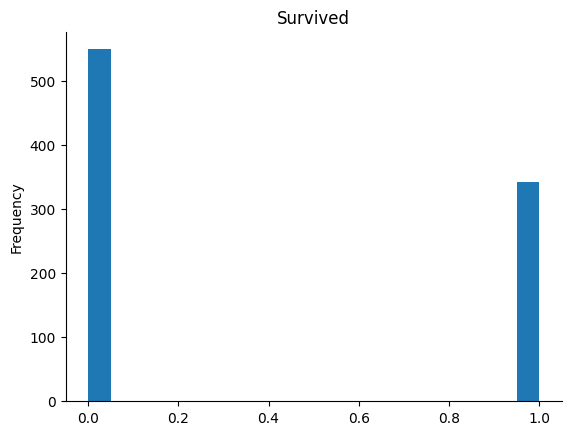

In [11]:
# @title Survived

from matplotlib import pyplot as plt
base['Survived'].plot(kind='hist', bins=20, title='Survived')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [12]:
base.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [13]:
base.tail(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
889,1,1,male,26.0,0,0,30.00,C
890,0,3,male,32.0,0,0,7.75,Q


**Contando quantidade de instâncias**


In [14]:
np.unique(base['Survived'], return_counts=True)

(array([0, 1]), array([549, 342]))

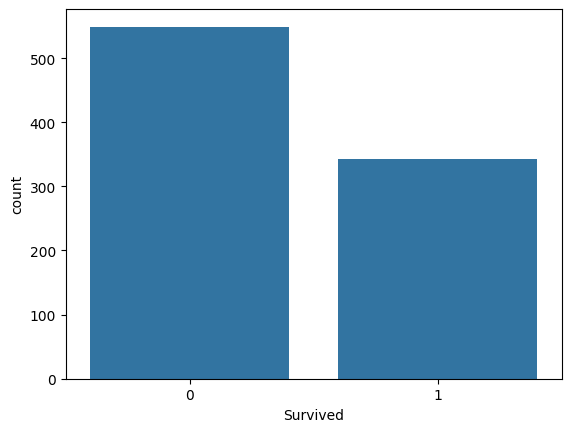

In [15]:
sns.countplot(x = base['Survived']);

**Tratamento de dados categóricos**

> *LabelEncoder - tratando a coluna "Sex"*



In [23]:
from sklearn.preprocessing import LabelEncoder

In [30]:
data_encoded = base.copy()

In [31]:
label_encoder = LabelEncoder()
data_encoded['Sex'] = label_encoder.fit_transform(data_encoded['Sex'])



> OneHotEncoder - binarizando os atributos não ordinais - "Embarked" e "Pclass"

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [33]:
# Aplicar OneHotEncoder para as colunas 'Embarked' e 'Pclass'
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)

In [34]:
# Codificar 'Embarked'
embarked_encoded = one_hot_encoder.fit_transform(data_encoded[['Embarked']])
embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=one_hot_encoder.get_feature_names_out(['Embarked']))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
# Codificar 'Pclass'
pclass_encoded = one_hot_encoder.fit_transform(data_encoded[['Pclass']])
pclass_encoded_df = pd.DataFrame(pclass_encoded, columns=one_hot_encoder.get_feature_names_out(['Pclass']))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
# Adicionando as colunas codificadas ao dataset original e remover as antigas
data_encoded = pd.concat([data_encoded, embarked_encoded_df, pclass_encoded_df], axis=1)
data_encoded.drop(['Embarked', 'Pclass'], axis=1, inplace=True)

In [37]:
# Verificando o resultado
data_encoded.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,1,22.0,1,0,7.2500,0.0,1.0,0.0,1.0
1,1,0,38.0,1,0,71.2833,0.0,0.0,0.0,0.0
2,1,0,26.0,0,0,7.9250,0.0,1.0,0.0,1.0
3,1,0,35.0,1,0,53.1000,0.0,1.0,0.0,0.0
4,0,1,35.0,0,0,8.0500,0.0,1.0,0.0,1.0


**Método de amostragem Holdout**

In [38]:
from sklearn.model_selection import train_test_split

In [40]:
import pickle

In [43]:
# separando os atributos e o alvo
X = data_encoded.drop(columns=['Survived'])
y = data_encoded['Survived']

In [44]:
# dividindo os dados entre treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# salvando os dados em um arquivo pickle
with open('sample_data/train.pkl', mode='wb') as f:
    pickle.dump([X_treino, X_teste, y_treino, y_teste], f)